In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb


import sys
sys.path.append('../')
from utils import *

In [2]:
is_kaggle = False

if is_kaggle:
    base_dir = '/kaggle/input'
    data_dir = f'{base_dir}/linking-writing-processes-to-writing-quality'
    output_dir = '/kaggle/working'
else:
    base_dir = '../'
    data_dir = f'{base_dir}/data'
    models_dir = f'{base_dir}/models'

In [3]:
train_feats = pd.read_csv('../feature_eng/example_features2.csv')

In [4]:
train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

# counter = 0
# new_columns = {}
# for col in cols:
#     if col != 'id' and col != 'score':
#         new_columns[col] = counter
#         counter += 1

# train_feats.rename(columns=new_columns, inplace=True)

In [5]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [6]:
train_feats.fillna(-999, inplace=True)
train_feats.replace([np.inf, -np.inf], -999, inplace=True)

In [19]:
def objective(trial,data=train_feats[train_cols],target=train_feats[target_col]):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15, random_state=42)

    params = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.6,0.8,0.9]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.6,0.8,0.9]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4,0.6,0.8,0.9]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9]),
        'eta': trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000, 1500, 1800, 2000, 2250, 2500]),
        'max_depth': trial.suggest_int('max_depth', 2, 5, step=1),
    }

    all_params = {
        'tree_method':'gpu_hist',
        'objective': 'reg:squarederror',
        'eval_metric': ['rmse'],
        'seed': 42,
        'nthread': -1,
        'early_stopping_rounds': 50,
        **params
    }


    model = xgb.XGBRegressor(**all_params)
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)], verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [20]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-19 21:16:29,981] A new study created in memory with name: no-name-0467de33-c355-4951-ac77-652e5eaf3fc6
[I 2023-12-19 21:16:35,105] Trial 0 finished with value: 2.114214636227694 and parameters: {'lambda': 0.37940041306211425, 'alpha': 0.009294556774749298, 'colsample_bytree': 0.4, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.8, 'subsample': 0.7, 'learning_rate': 0.0003326738341416802, 'n_estimators': 1500, 'max_depth': 2}. Best is trial 0 with value: 2.114214636227694.
[I 2023-12-19 21:16:40,644] Trial 1 finished with value: 0.6364131365731766 and parameters: {'lambda': 0.038546066841937315, 'alpha': 0.00877622251675818, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.4, 'subsample': 0.5, 'learning_rate': 0.0017614472859975615, 'n_estimators': 1500, 'max_depth': 3}. Best is trial 1 with value: 0.6364131365731766.
[I 2023-12-19 21:16:48,888] Trial 2 finished with value: 3.3481506343907186 and parameters: {'lambda': 2.7634998100208636, 'alpha': 0.04

Number of finished trials: 100
Best trial: {'lambda': 6.29525858048249, 'alpha': 0.0034859671182548204, 'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.008083203116849208, 'n_estimators': 2250, 'max_depth': 3}


In [21]:
study.trials_dataframe().sort_values(by='value', ascending=True).head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bylevel,params_colsample_bynode,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,state
96,96,0.554149,2023-12-19 21:24:58.740064,2023-12-19 21:25:02.770850,0 days 00:00:04.030786,0.003486,0.4,0.8,0.8,6.295259,0.008083,3,2250,0.8,COMPLETE
75,75,0.555057,2023-12-19 21:23:08.835501,2023-12-19 21:23:13.784572,0 days 00:00:04.949071,0.002353,0.4,0.8,0.8,5.834719,0.006456,3,2000,0.9,COMPLETE
80,80,0.555247,2023-12-19 21:23:38.332306,2023-12-19 21:23:44.252623,0 days 00:00:05.920317,0.003846,0.4,0.8,0.8,6.673379,0.004875,4,2000,0.7,COMPLETE
21,21,0.555405,2023-12-19 21:18:39.581746,2023-12-19 21:18:44.577648,0 days 00:00:04.995902,0.002935,0.6,0.8,0.9,9.359074,0.005167,3,2000,0.7,COMPLETE
98,98,0.555554,2023-12-19 21:25:05.797801,2023-12-19 21:25:10.456751,0 days 00:00:04.658950,0.004162,0.4,0.8,0.8,5.678881,0.006610,3,2250,0.8,COMPLETE


## Use best params

In [22]:
best_trial = study.best_trial.params
print(best_trial)

{'lambda': 6.29525858048249, 'alpha': 0.0034859671182548204, 'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.008083203116849208, 'n_estimators': 2250, 'max_depth': 3}


In [23]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

In [24]:
models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []

for i in range(3): 
    kf = model_selection.KFold(n_splits=20, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

        best_params = {
            'tree_method':'hist',
            'objective': 'reg:squarederror',
            'eval_metric': ['rmse'],
            'seed': 42,
            'nthread': -1,
            'early_stopping_rounds': 50,
            **best_trial
        }
        
        model = xgb.XGBRegressor(**best_params)
        
        model.fit(X_train,y_train, eval_set=[(X_valid,y_valid)], verbose=False)

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [25]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))

In [26]:
print('OOF metric XGB = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means,
                                                                   squared=False)))

OOF metric XGB = 0.60452


In [27]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [28]:
import math
def round_to_half(numbers, round_up=False):
    if round_up:
        return [round(num * 2) / 2 for num in numbers]
    else:
        return [math.floor(num * 2) / 2 for num in numbers]

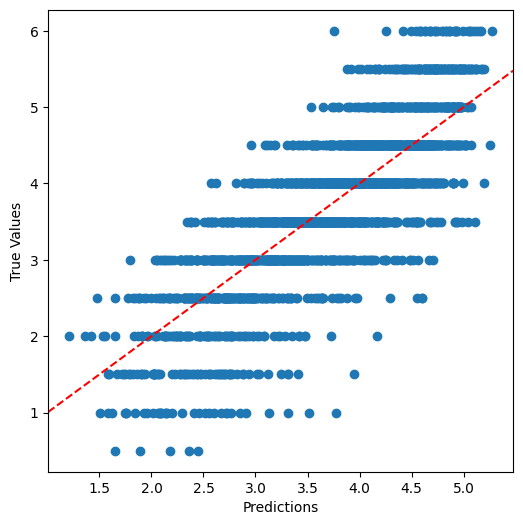

In [29]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

(array([569., 930., 548., 266.,  90.,  37.,  20.,   7.,   3.,   1.]),
 array([0.00029866, 0.01709666, 0.03389466, 0.05069266, 0.06749067,
        0.08428867, 0.10108667, 0.11788467, 0.13468267, 0.15148067,
        0.16827868]),
 <BarContainer object of 10 artists>)

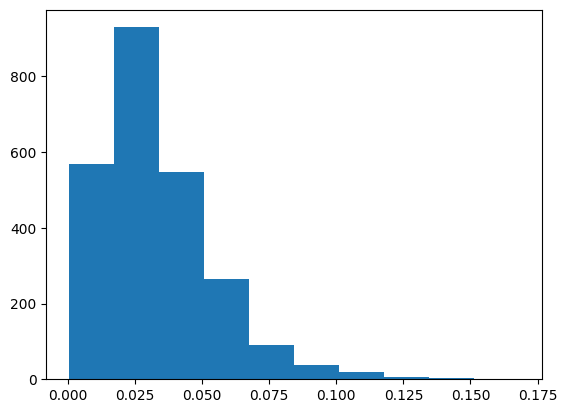

In [30]:
plt.hist(stds)